# Skin Lesion  Classification 

Name: Bency Sundar\
Email: bencysundar1@gmail.com

## TABLE of Contents
1. [Introduction](#introduction)
2. [Importing Libraries](#lib)
3. [Loading the data](#load)
4. [Extracting and reading the data](#extract)
5. [Data Wrangling](#wrangle)
6. [EDA](#eda)
7. [Preprocessing the images](#process)
8. [Iteration 1-SVM](#1)
9. [Iteration 2-CNN](#2)
10. [Iteration 3-Smote](#3)
11. [Iteration 4-Data Augumentation](#4)
12. [Iteration 5-Transfer learning](#5)
13. [Comparision of iteration](#comp)
13. [Conclusion](#con)



## Introduction<a name="introduction"></a>

Skin cancer is a highy treatable cancer with early detection.The biggest struggle with identification of Skin Cancer  is the minute variation between abnormal growth and normal growth. To a naked eye the resemblance remains the same. 

This project aims to build an automated classification to classify the skin lesion which  is an important first step for classification of Skin Cancer.This will help Physicians tackle the skin cancer identification at a much faster rate.
The dataset used for this project was taken from ISIC challenge.The dataset was provided to public to provide a diverse and large rangle of images for lesion detection.

 Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
 - Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
 - basal cell carcinoma (bcc)
 - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
 - dermatofibroma (df)
 - melanoma (mel)
 - melanocytic nevi (nv)
 - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). 


## Objective

The objective of this notebook  is to build a model that can help physicians diagnois the pigmented skin lesion by analyzing the different  lesion images and predicting the lesion type.

In [1]:
pip install imbalanced-learn


  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


## Importing essential Libraries<a name="lib"></a>

In [2]:
#Importing the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

#Libraries for merging folders
import os #interacting with the os
import glob #Finding files using the the pattern


#Image preprocessing 
from PIL import Image #for image manipulation
from skimage.io import imread

#train test split 
from sklearn.model_selection import train_test_split



#Tensorflow packages
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import VGG16

#Packages for SVM model

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#Packages for evlation
from sklearn.metrics import confusion_matrix

#Packages for class imbalance

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

2023-09-07 21:58:22.295632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 21:58:43.810617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-07 21:58:43.864016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Loading the Data <a name="load"></a>

In [3]:
meta_data_file = 'archive/HAM10000_metadata.csv'

In [4]:
#Loading the metadate 
skin_df = pd.read_csv(meta_data_file)

In [5]:
#Defining the path to images and metadata

image_folder1 = 'archive/HAM10000_images_part_1'
image_folder2 = 'archive/HAM10000_images_part_2'
meta_data_file = 'archive/HAM10000_metadata.csv'

## Extracting and reading the data <a name="extract"></a>

We need to extract the image path from the folders and merge it with the metadata 

In [6]:
#Loading the metadate 
skin_df = pd.read_csv(meta_data_file)

#Creating a dictionary to store the image path

image_path = {}

#Populating the image paths with the image files from the folder
image_files1 = glob.glob(os.path.join(image_folder1,'*jpg'))
image_files2 = glob.glob(os.path.join(image_folder2,'*jpg'))

for file in image_files1:
    #extracting thr image id
    image_id = os.path.splitext(os.path.basename(file))[0]
    #store the image path in the dictionary with the image id
    image_path[image_id] = file
    
for file in image_files2:
    #extracting thr image id
    image_id = os.path.splitext(os.path.basename(file))[0]
    #store the image path in the dictionary with the image id
    image_path[image_id] = file

In [7]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [8]:
#merging the meta data with the image paths
skin_df['image_path'] = skin_df['image_id'].map(image_path)

In [9]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0                                              NaN  
1                                              NaN  
2                                              NaN  
3                                              NaN  
4  archive/HAM10000_images_part_2/ISIC_0031633.jpg

Since the dx column in metadata represents the lesion_type let's replace the dx column with the actual name of the lesions for easier understanding 

In [10]:
#lets take a look at the 'dx' column
unique_lesions = skin_df['dx'].unique()
print(unique_lesions)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


Using the NIH https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7445643/ the following dictionary was created.

In [11]:
#Creation a lesion_type dictionary 

lesion_type  = {
    'bkl': 'Benign lesions of the keratosis',
    'nv': 'Melanocytic nevi',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'vasc':'Vascular lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma'  
    
}

In [12]:
#Creating a new column that represents the lesions type 
skin_df['lesion_type'] = skin_df['dx'].map(lesion_type)


In [13]:
#Creating a lesion_type_id for each class in the target variable

class_id ={
    'bkl': 0,
    'nv': 1,
    'df': 2,
    'mel': 3,
    'vasc':4,
    'bcc': 5,
    'akiec': 6  
}

In [14]:
#Creating a new column that represents the class_id
#Creating a new column that represents the lesions type 
skin_df['class_id'] = skin_df['dx'].map(class_id)

In [15]:
skin_df.shape


(10015, 10)

In [16]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4  archive/HAM10000_images_part_2/ISIC_0031633.jpg   

                       lesion_type  class_id  
0  Benign lesions of the keratosis         0  
1  Benign lesions of the keratosis         0  
2  Benign lesions of the keratosis         0  
3  Benign lesions of the keratosis         0  
4  Benign lesions of the keratosis         0

Now we have the image folders mergred into one and joined with the meta data.

To avoid multicollinearity lets drop the dx column

In [17]:
skin_df.drop('dx',axis=1,inplace=True)

In [18]:
skin_df.head()

lesion_id      image_id dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633   histo  75.0  male          ear   

                                        image_path  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4  archive/HAM10000_images_part_2/ISIC_0031633.jpg   

                       lesion_type  class_id  
0  Benign lesions of the keratosis         0  
1  Benign lesions of the keratosis         0  
2  Benign lesions of the keratosis         0  
3  Benign lesions of the keratosis         0  
4  Benign lesions of the keratosis         0

## Cleaning the dataset <a name="wrangle"></a>

#### 1. Lets check for null values in this dataset


In [19]:
# checking for columns with null values
skin_df.isna().sum()

lesion_id          0
image_id           0
dx_type            0
age               57
sex                0
localization       0
image_path      6656
lesion_type        0
class_id           0
dtype: int64

Since we are dealing with medical records it is best pratice to always drop null values in order to reduce the amibiguity that the data present

In [20]:
# dropping columns with null values
skin_df.dropna(inplace = True)

In [21]:
#check the dataframe again
skin_df.isna().sum()


lesion_id       0
image_id        0
dx_type         0
age             0
sex             0
localization    0
image_path      0
lesion_type     0
class_id        0
dtype: int64

#### 2. handling duplicates

In [22]:
#Count the number of duplicated rows
skin_df.duplicated().sum()

0

There are no duplicated rows in this dataset

#### 3.  Checking the datatype 

In [23]:
skin_df.dtypes

lesion_id        object
image_id         object
dx_type          object
age             float64
sex              object
localization     object
image_path       object
lesion_type      object
class_id          int64
dtype: object

Let's convert the age data type from float to int and round off the values

In [24]:
lesion_df = skin_df.copy()

In [25]:
lesion_df['age']= lesion_df['age'].astype(int).round() 

In [26]:
lesion_df.dtypes

lesion_id       object
image_id        object
dx_type         object
age              int64
sex             object
localization    object
image_path      object
lesion_type     object
class_id         int64
dtype: object

#### 4. Renaming the columns 

According to the Hardvard dataverse "more than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal)."

The above implies that the dx_type is more of a examination  method so for clarity let us rename the column 

In [27]:
lesion_df.rename(columns = {'dx_type':'exam_method'},inplace = True)

In [28]:
lesion_df.head()

lesion_id      image_id exam_method  age     sex     localization  \
4   HAM_0001466  ISIC_0031633       histo   75    male              ear   
11  HAM_0004234  ISIC_0029396       histo   85  female            chest   
15  HAM_0007207  ISIC_0031326       histo   65    male             back   
17  HAM_0001601  ISIC_0031029       histo   75    male  upper extremity   
18  HAM_0007571  ISIC_0029836       histo   70    male            chest   

                                         image_path  \
4   archive/HAM10000_images_part_2/ISIC_0031633.jpg   
11  archive/HAM10000_images_part_2/ISIC_0029396.jpg   
15  archive/HAM10000_images_part_2/ISIC_0031326.jpg   
17  archive/HAM10000_images_part_2/ISIC_0031029.jpg   
18  archive/HAM10000_images_part_2/ISIC_0029836.jpg   

                        lesion_type  class_id  
4   Benign lesions of the keratosis         0  
11  Benign lesions of the keratosis         0  
15  Benign lesions of the keratosis         0  
17  Benign lesions of the keratosis         0  
18  Benign lesions of the keratosis         0

In [29]:
lesion_df.shape


(3351, 9)

## EDA <a name="eda"></a>

Let's explore the different features of the dataset

In [30]:
lesion_df.describe(include ='all')

lesion_id      image_id exam_method          age   sex  \
count          3351          3351        3351  3351.000000  3351   
unique         3072          3351           4          NaN     3   
top     HAM_0003789  ISIC_0031633       histo          NaN  male   
freq              4             1        1638          NaN  1814   
mean            NaN           NaN         NaN    52.484333   NaN   
std             NaN           NaN         NaN    16.345550   NaN   
min             NaN           NaN         NaN     0.000000   NaN   
25%             NaN           NaN         NaN    40.000000   NaN   
50%             NaN           NaN         NaN    50.000000   NaN   
75%             NaN           NaN         NaN    65.000000   NaN   
max             NaN           NaN         NaN    85.000000   NaN   

           localization                                       image_path  \
count              3351                                             3351   
unique               14                                             3351   
top     lower extremity  archive/HAM10000_images_part_2/ISIC_0031633.jpg   
freq                721                                                1   
mean                NaN                                              NaN   
std                 NaN                                              NaN   
min                 NaN                                              NaN   
25%                 NaN                                              NaN   
50%                 NaN                                              NaN   
75%                 NaN                                              NaN   
max                 NaN                                              NaN   

             lesion_type     class_id  
count               3351  3351.000000  
unique                 7          NaN  
top     Melanocytic nevi          NaN  
freq                2300          NaN  
mean                 NaN     1.552969  
std                  NaN     1.472367  
min                  NaN     0.000000  
25%                  NaN     1.000000  
50%                  NaN     1.000000  
75%                  NaN     1.000000  
max                  NaN     6.000000

#### 1. Distribution of sex 

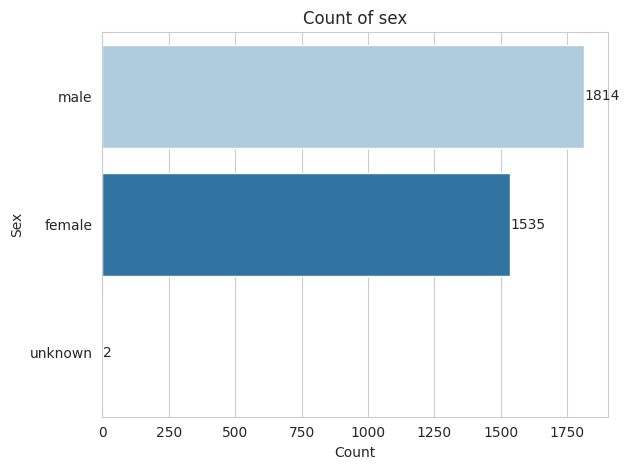

In [31]:
#Countplot creation
sns.set_style('whitegrid')
new =sns.countplot(data =lesion_df, y='sex', palette ='Paired', order = lesion_df['sex'].value_counts().index)
for containers in new.containers:
    new.bar_label(containers)
    
#Setting the title and labels
plt.title('Count of sex')
plt.xlabel('Count')
plt.ylabel('Sex')

plt.tight_layout()
plt.show()

Observation:
- We have more lesions detected in male compared to women
- There is a small portion of unknown present in the table <br>
- The difference between counts in male and female is not significantly different<br>

In [32]:
#Exploring the unknowns
sex_counts = lesion_df['sex'].value_counts()
print(sex_counts)

male       1814
female     1535
unknown       2
Name: sex, dtype: int64


The count for unknown is quite low, lets take a look at what lesion type has unknowns

In [33]:
unknown_samples = lesion_df[lesion_df['sex'] == 'unknown']
unknown_lesion_types = unknown_samples['lesion_type'].unique()
print(unknown_lesion_types)

['Melanocytic nevi']


Since the unknown is a very small compared to the other sexes, removing them will not affect the dataset 


In [34]:
#drop rows with 'unknown' sex
lesion_df = lesion_df[lesion_df['sex']!='unknown']

In [35]:
#Reseting the index
lesion_df.reset_index(drop = True, inplace =True)

In [36]:
#Verifying the drop
print(lesion_df ['sex'].value_counts())

male      1814
female    1535
Name: sex, dtype: int64


#### 2. Distribution of the lesion_type

Text(0.5, 1.0, 'Distribution of lesion type')

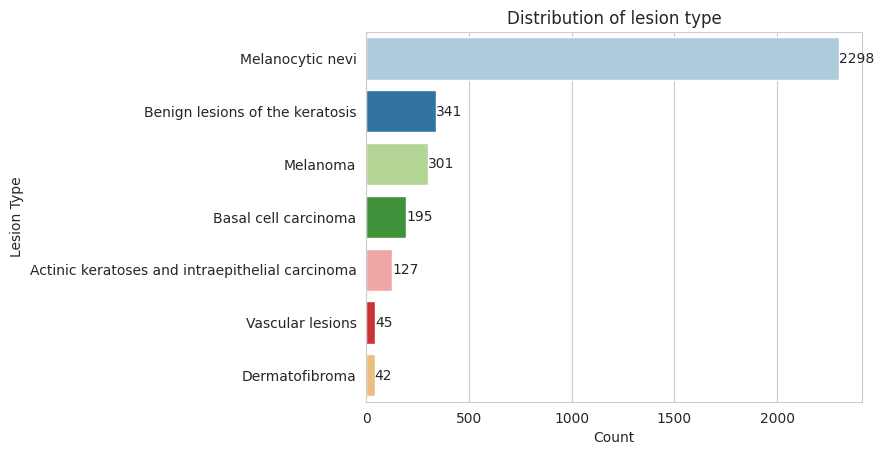

In [37]:

sns.set_style('whitegrid')
new = sns.countplot(data = lesion_df, y = 'lesion_type',palette ='Paired', order = lesion_df['lesion_type'].value_counts().index)
for containers in new.containers:
    new.bar_label(containers)
plt.ylabel("Lesion Type")
plt.xlabel("Count")
plt.title("Distribution of lesion type")



Obsrvations
- The melanocytic nevi is the medical term for mole and it appears to be the common type of lesion observed than the rest of the lesion type. 
- Since the Lesion_type is the target variable we can clearly see that there is  a  class imbalance in the target variable.


#### 3. Visualizing the distribution of the age:


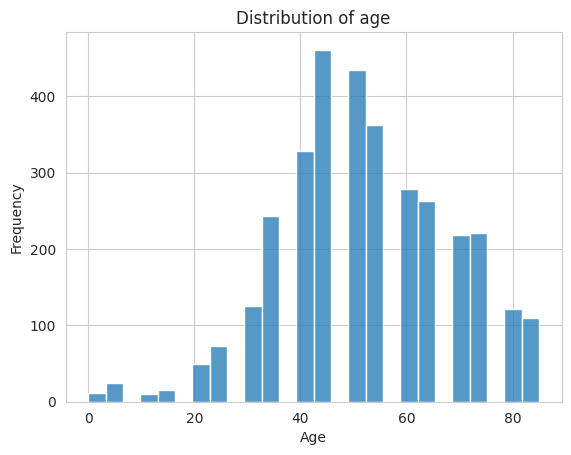

In [38]:
sns.set_style('whitegrid')
sns.histplot(lesion_df['age'])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of age")
plt.show()

Observation
- From the above graph we can infer that for the skin cancer occurance is more between the ages of 40 to 50. 
- The frequency of lesion increases gradually and reaches its peak around 45 and then falls back gradually.
- the reason for more cases as the age increases maybe because of more accumulation of UV exposure and the timeline of the ozone layer depletion.

#### 4. Distribution of the localization and lesion type 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'lower extremity'),
  Text(1, 0, 'back'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'neck'),
  Text(9, 0, 'scalp'),
  Text(10, 0, 'hand'),
  Text(11, 0, 'unknown'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear')])

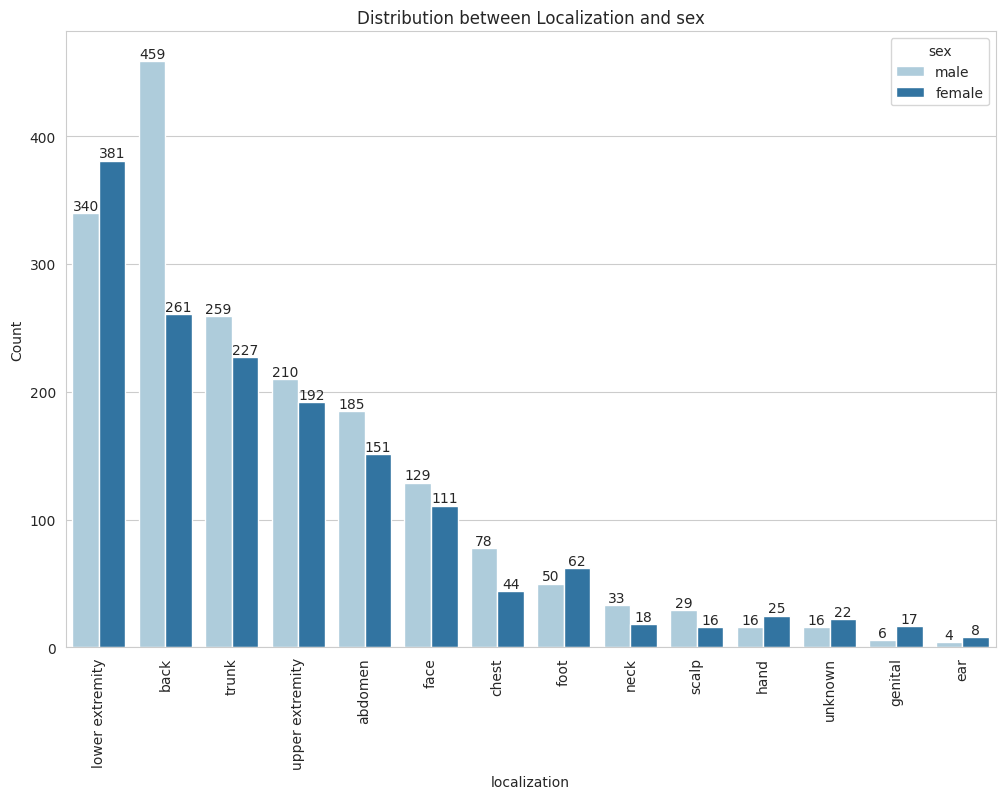

In [39]:
plt.figure(figsize = (12,8))
sns.set_style('whitegrid')
new= sns.countplot(data = lesion_df, x='localization', hue ='sex',palette = 'Paired', order = lesion_df['localization'].value_counts().index)
plt.title("Distribution between Localization and sex")
for containers in new.containers:
    new.bar_label(containers)
plt.xlabel('localization')
plt.ylabel('Count')
plt.xticks(rotation =90)

Observation
- The most common place for lesion is the back for male
- For a female it is the lower extremity which is the leg,ankle and foot


#### 5. Frequency fo exam method

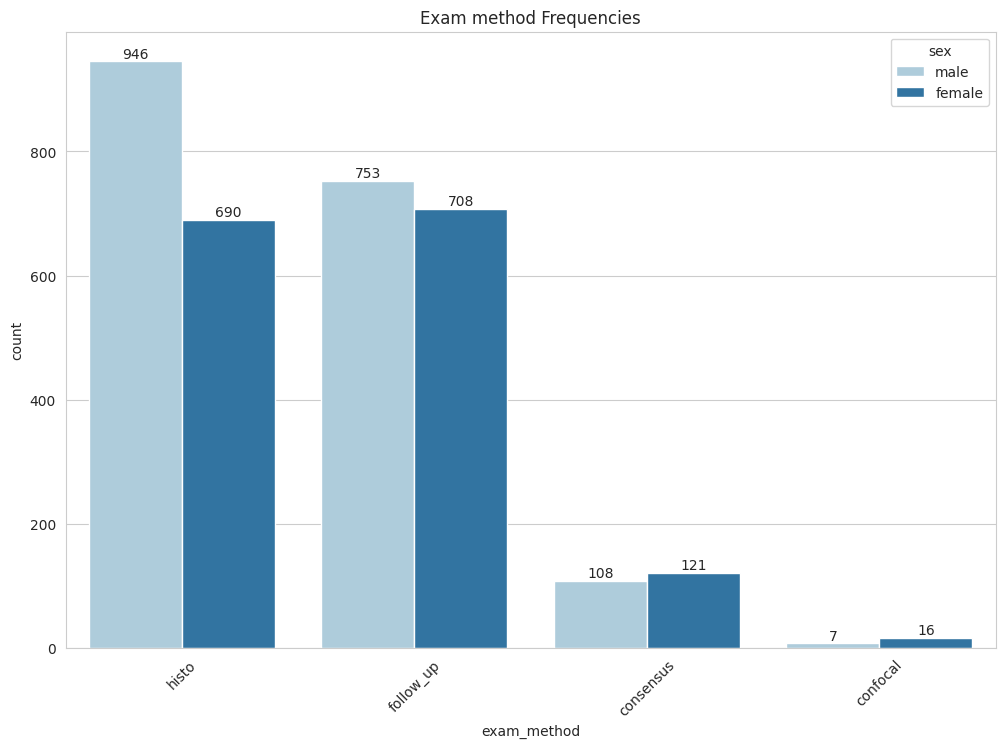

In [40]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
new = sns.countplot(x='exam_method',hue='sex', data=lesion_df, order = lesion_df['exam_method'].value_counts().index, palette = 'Paired')
for container in new.containers:
    new.bar_label(container)
plt.title('Exam method Frequencies')
plt.xticks(rotation=45)
plt.show()

Observations:
- The most common type of examination method was histo 
  - According to hee.nhs.uk Histopathology involves the diagnosis and study of diseases of the tissues by examining tissues and/or cells under a microscope. 
- The second most common type of examination method is follow up with the doctor after initial examination

#### 6.Distribution between localization and exam_method

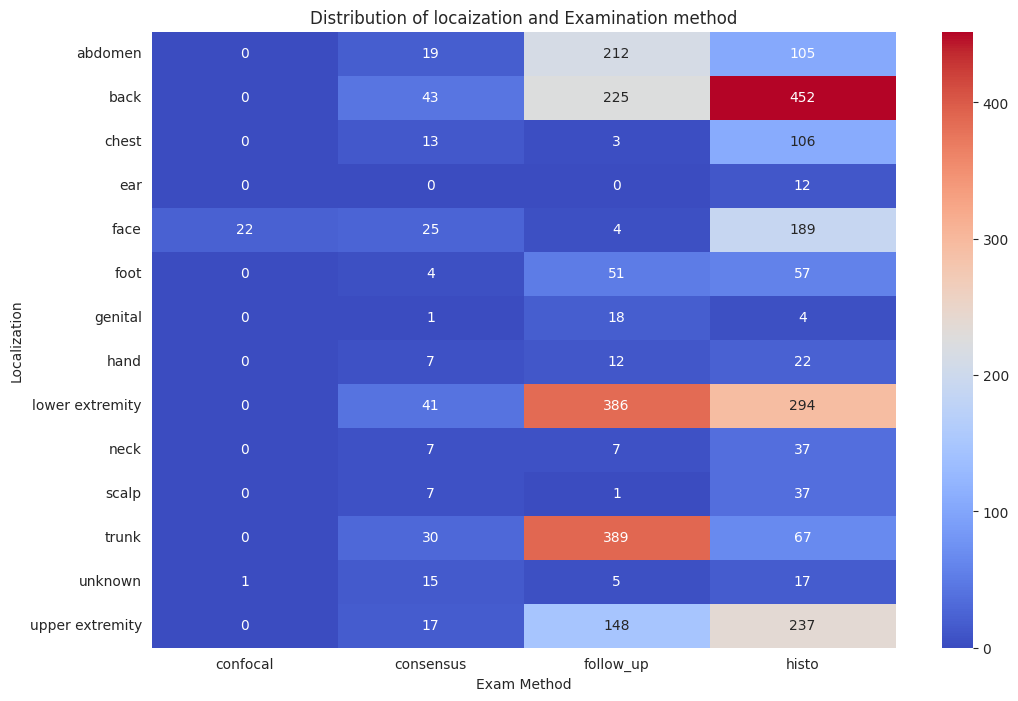

In [41]:
pivot = lesion_df.pivot_table(index="localization",columns ="exam_method",aggfunc = "size",fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot,annot=True,cmap='coolwarm',fmt ="d")

plt.xlabel("Exam Method")
plt.ylabel("Localization")
plt.title("Distribution of locaization and Examination method")

plt.show()

Observations
- For histopathology we can see that the most common type of localization is back
- For follw-ups it is trunk area
- For consensus the most common localization is also back
- For confocal it look like most common is head region
    - According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6092073/ the most useful type of diagonistic tool  for face lesion is confocal microscopy

#### 7. Distribution of lesions and Sex

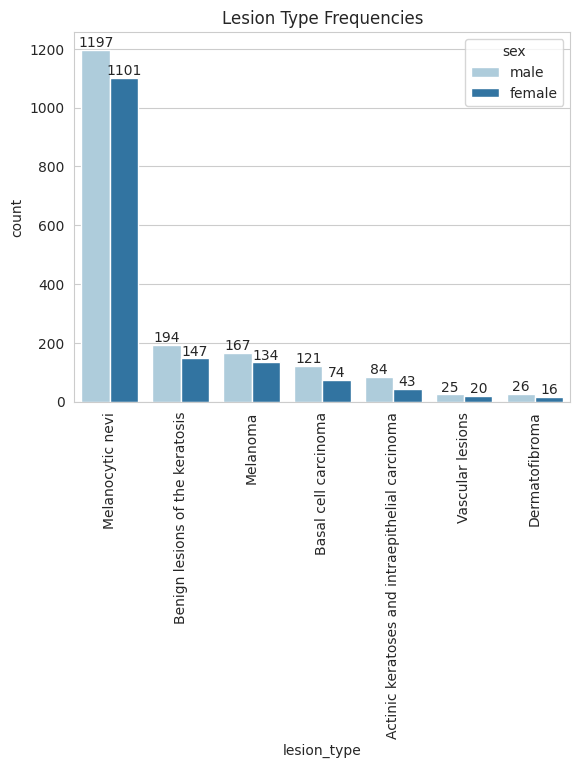

In [42]:


sns.set_style('whitegrid')

new = sns.countplot(x='lesion_type',hue='sex', data=lesion_df, order = lesion_df['lesion_type'].value_counts().index, palette = 'Paired')
for container in new.containers:
    new.bar_label(container)
plt.title('Lesion Type Frequencies')
plt.xticks(rotation=90)
plt.show()

Observation:
   - the lesion type frequencies is similar to male and female but male has more number of cases in every lesion type than the female.
   - As mentioned earlier we can see that it is male has a higher risk of skin cancer compared to female. 
  
    

#### 8. Genderwise and age distribution

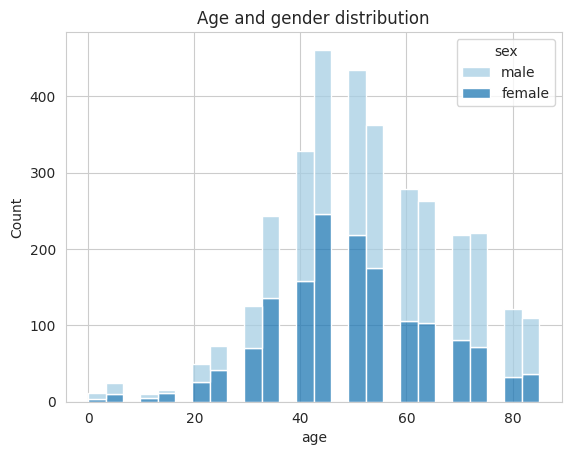

In [43]:
sns.set_style('whitegrid')
fig = sns.histplot(data = lesion_df, x='age', hue='sex',multiple = 'stack',palette ='Paired')
plt.title('Age and gender distribution')
plt.show()

Observation
- Overall the prominence of skin cancer can be found in male, 
- The highest is at 40 for both male and female and least around the age of 10. 

#### 9. Distribution of cell type and age

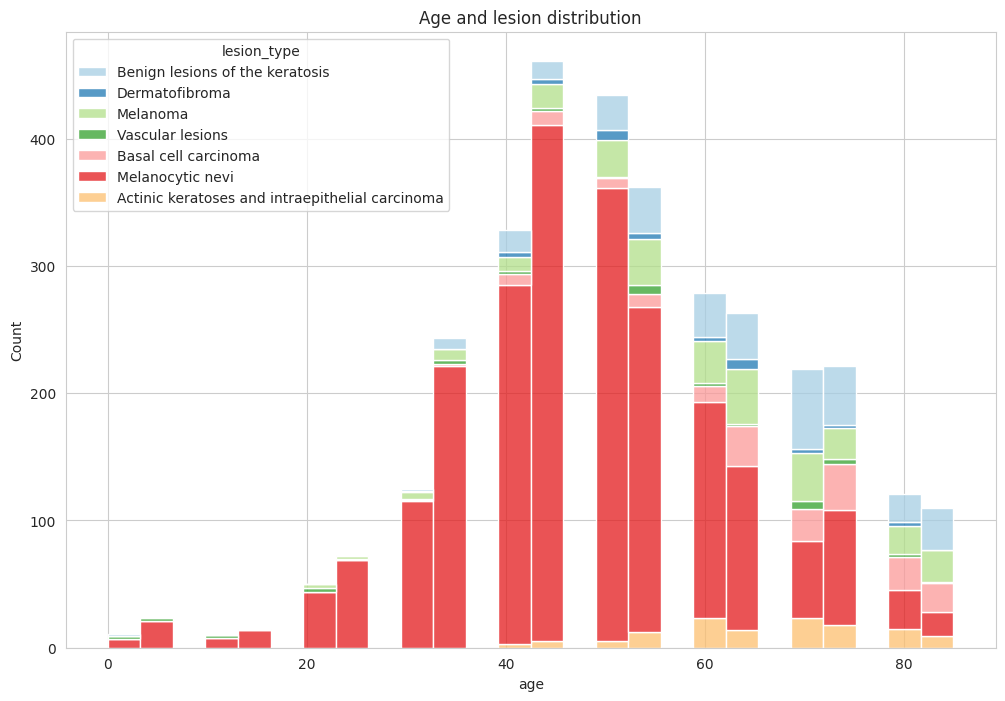

In [44]:
sns.set_style('whitegrid')
fid,axes = plt.subplots(figsize = (12,8))
fig = sns.histplot(data = lesion_df, x='age', hue='lesion_type',multiple = 'stack',palette ='Paired')
plt.title('Age and lesion distribution')
plt.show()

Observation
- Melanocytic nevi(mole) is the common lesion type 
- At age 40 we can see an increase in melanoma and  actinic keratosis, melanoma type skin lesion are cancerous and actinic leratosis are precancerous skin lesion.

## Preprocessing the Images <a name="process"></a>

### Load in all the image


Let's load the images in the specified image path ad convert it into a numpy array and store it in image column and analyze the distribution

In [45]:
image_df = lesion_df.copy()

In [46]:
image_df['image'] = image_df['image_path'].map(lambda x:np.array(Image.open(x)))

In [47]:
#See the image siz e distribution
image_df['image'].map(lambda x:x.shape).value_counts()

(450, 600, 3)    3349
Name: image, dtype: int64

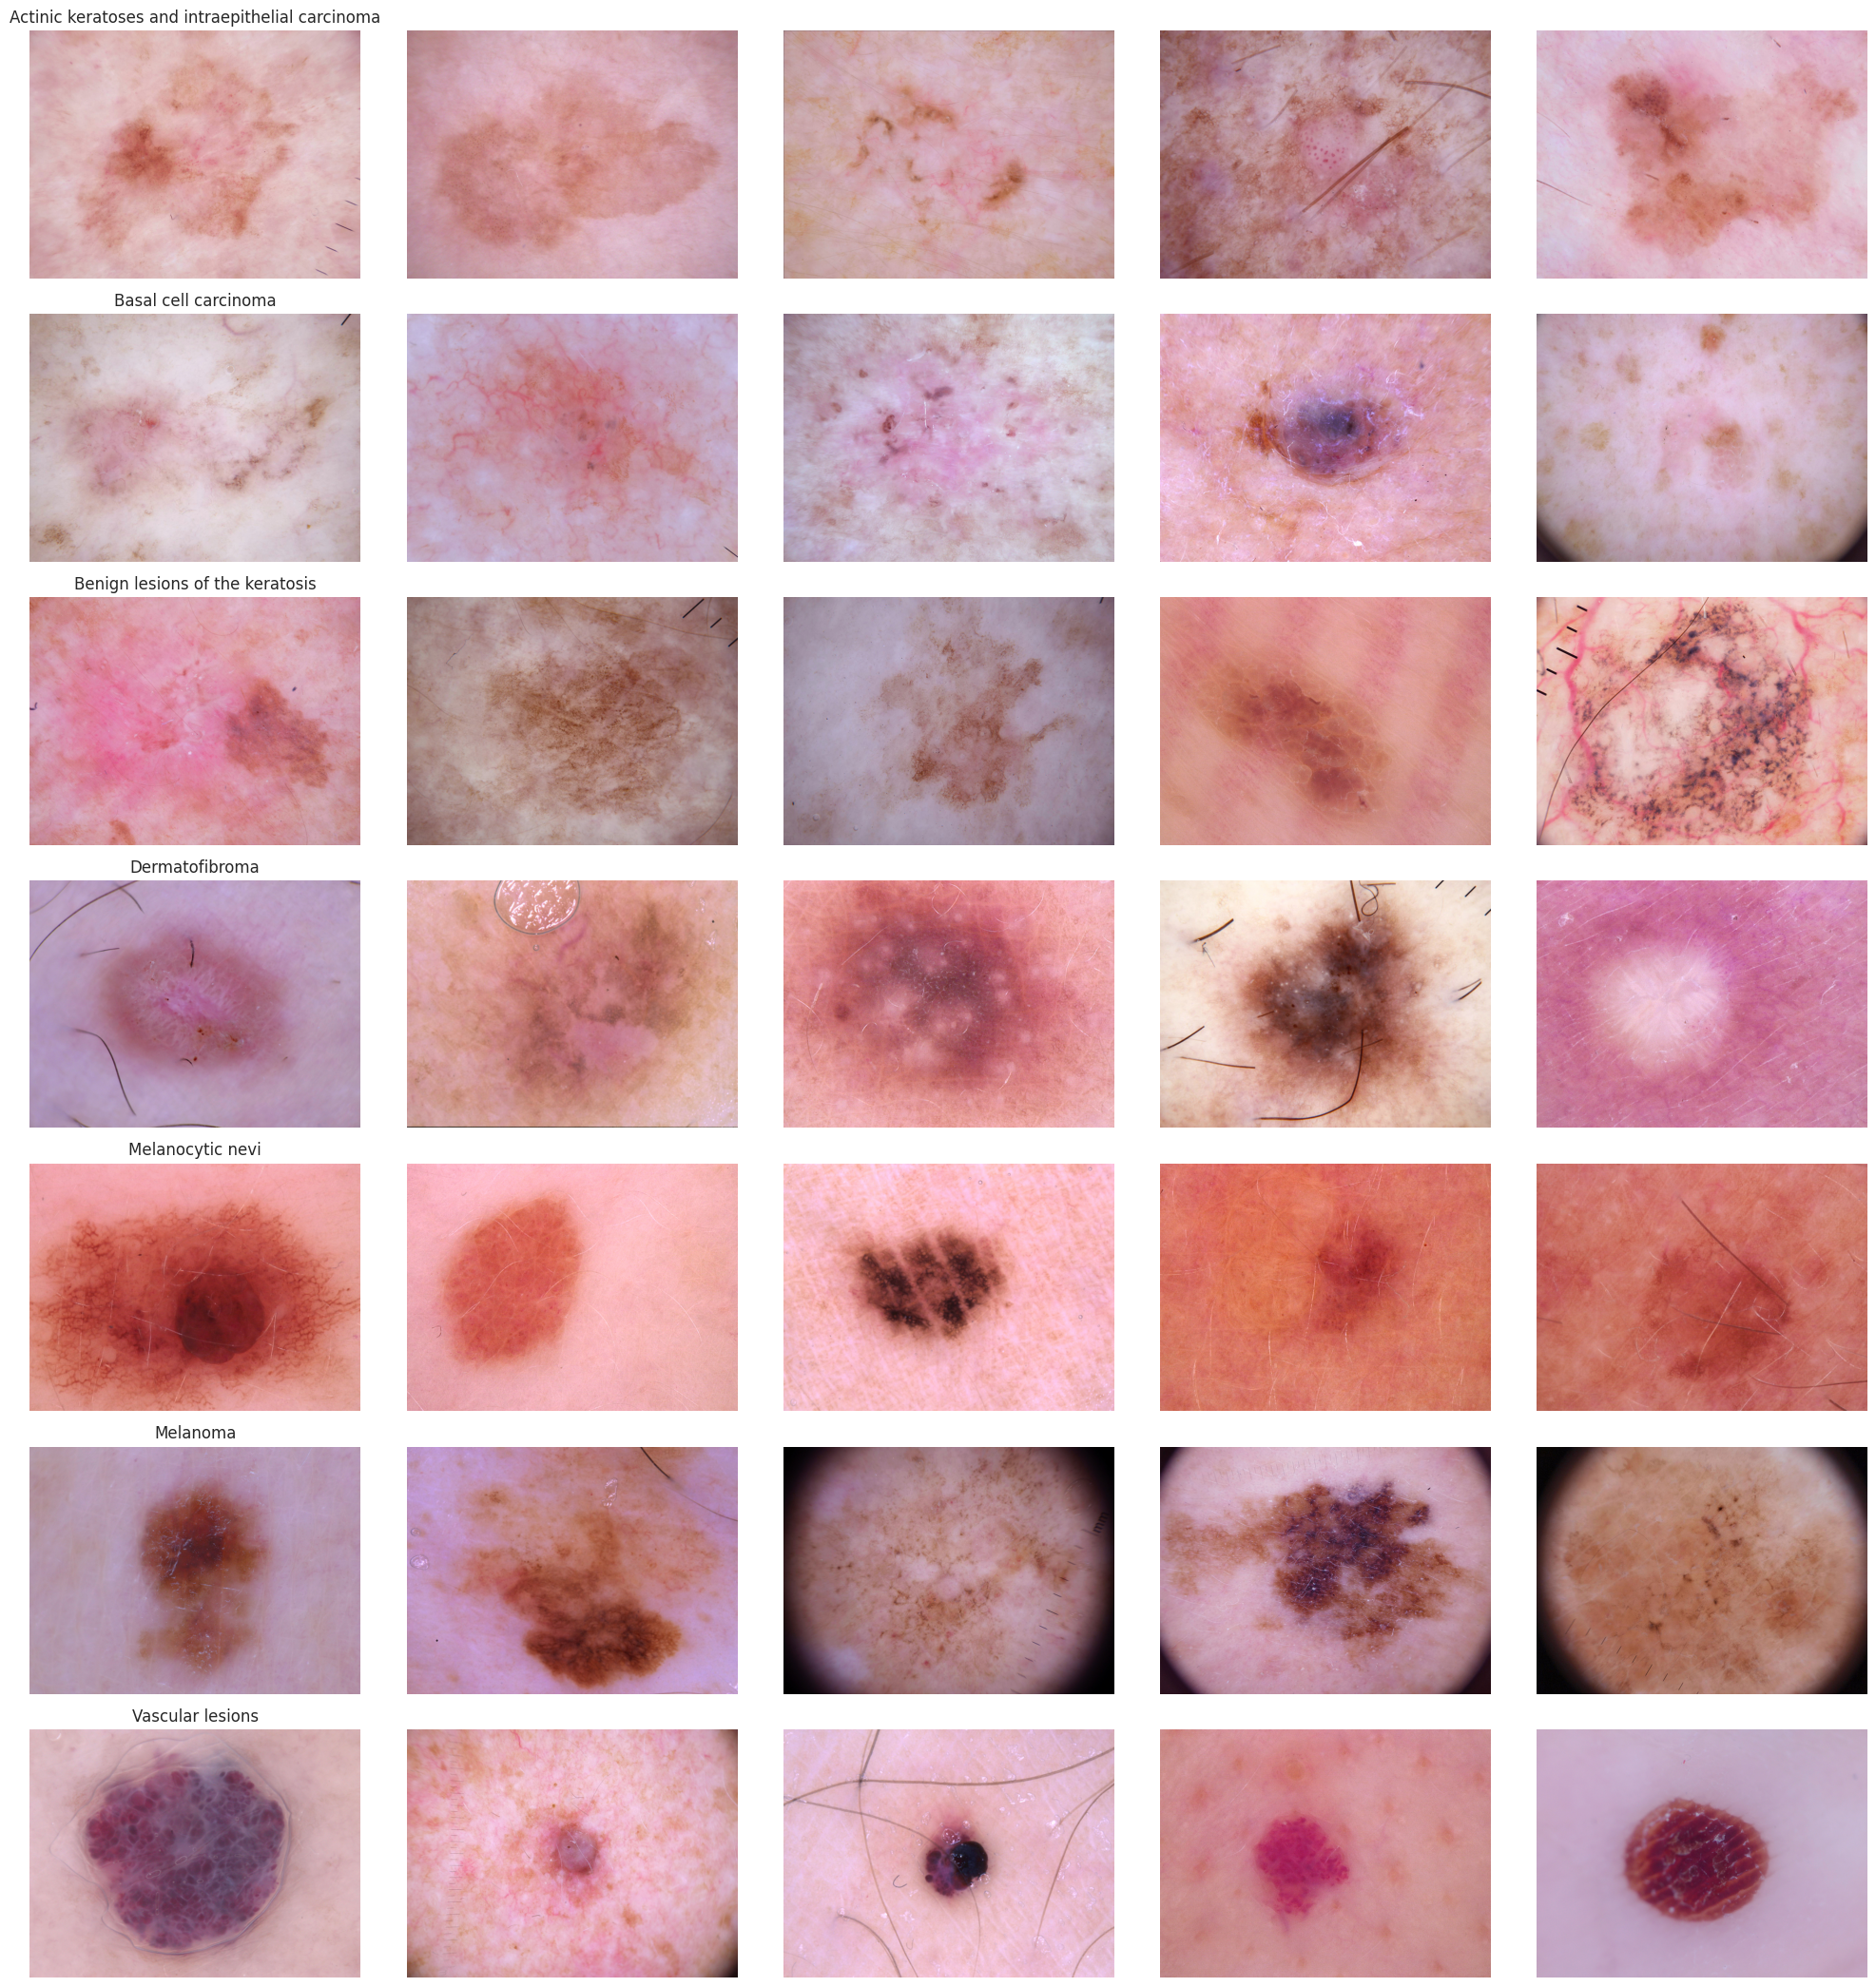

In [48]:
n_samples = 5


#Grouping the data by lesion type 

grouped_df = image_df.sort_values('lesion_type').groupby ('lesion_type')

#Calculate the number of rows needed for the the subplot grid

n_rows =len(grouped_df)

fig,axs = plt.subplots(n_rows,n_samples,figsize = (4*n_samples,3*n_rows))

#Loop through for each lesion type 

for row_id,(lesion_type,cell_rows) in enumerate (grouped_df):
    axs[row_id,0].set_title(lesion_type)
    
    sample_rows = cell_rows.sample(n_samples,random_state = 15
                                  )
    
    for col_id, (_, sample_rows) in enumerate (sample_rows.iterrows()):
        axs[row_id, col_id].imshow(sample_rows['image'])
        axs[row_id, col_id].axis('off')

plt.tight_layout()

plt.savefig('category_sample.png',dpi = 300)
plt.show()
    

From the above we can that the 7 classes of skin lesion is similair and has fine variation in the appearance of the skin lesions

#### 1. Resizing the image

In [49]:
image_df['image'] =image_df['image_path'].map(lambda x:np.array(Image.open(x).resize((100,75))))

In [50]:
image_df.head()

lesion_id      image_id exam_method  age     sex     localization  \
0  HAM_0001466  ISIC_0031633       histo   75    male              ear   
1  HAM_0004234  ISIC_0029396       histo   85  female            chest   
2  HAM_0007207  ISIC_0031326       histo   65    male             back   
3  HAM_0001601  ISIC_0031029       histo   75    male  upper extremity   
4  HAM_0007571  ISIC_0029836       histo   70    male            chest   

                                        image_path  \
0  archive/HAM10000_images_part_2/ISIC_0031633.jpg   
1  archive/HAM10000_images_part_2/ISIC_0029396.jpg   
2  archive/HAM10000_images_part_2/ISIC_0031326.jpg   
3  archive/HAM10000_images_part_2/ISIC_0031029.jpg   
4  archive/HAM10000_images_part_2/ISIC_0029836.jpg   

                       lesion_type  class_id  \
0  Benign lesions of the keratosis         0   
1  Benign lesions of the keratosis         0   
2  Benign lesions of the keratosis         0   
3  Benign lesions of the keratosis         0   
4  Benign lesions of the keratosis         0   

                                               image  
0  [[[134, 90, 113], [147, 102, 125], [159, 115, ...  
1  [[[152, 122, 123], [153, 123, 123], [158, 129,...  
2  [[[194, 157, 178], [197, 156, 178], [200, 159,...  
3  [[[212, 162, 176], [212, 163, 177], [212, 162,...  
4  [[[157, 127, 132], [165, 133, 138], [169, 134,...

In [51]:
#See the image siz e distribution
image_df['image'].map(lambda x:x.shape).value_counts()

(75, 100, 3)    3349
Name: image, dtype: int64

In [52]:
X = image_df.drop(columns =['class_id'],axis = 1)
y = image_df['class_id']

 #### 4.Train_Test Split

In [53]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y, test_size= 0.20, random_state=20)

#### 3. Normalization the image

In [54]:
X_train =np.array(X_train1['image'].tolist())
X_test = np.array(X_test1['image'].tolist())


#Find the minimum and maximum pixel values in the entire dataset

min_value_train = np.min(X_train)
min_value_test = np.min(X_test)

#Find the overall minimum pixel value across both sets

min_value = min(min_value_train, min_value_test)

#Normalize the pixel values using min-max scaling
X_train =(X_train - min_value)/(np.max(X_train)-min_value)
X_test =(X_test - min_value)/(np.max(X_test)-min_value)

#### 6. Label coding

In [55]:
#Perform one hot encoding

y_train = to_categorical(y_train1, num_classes= 7)
y_test = to_categorical(y_test1, num_classes= 7)

#### 5. Validation Splitting

In [56]:
X_train,X_val,y_train,y_val =train_test_split(X_train,y_train,test_size=0.1,random_state=12)

#### 7. Reshape image array

In [57]:
#Reshaping the image array 

X_train = X_train.reshape(X_train.shape[0],*(75,100,3))
X_test = X_test.reshape(X_test.shape[0],*(75,100,3))
X_val = X_val.reshape(X_val.shape[0],*(75,100,3))


## ITERATION 1 -SVM <a name="1"></a>

As this is a multiclass classification problem we will use SVM as a baseline model

In [58]:
#Flatten the image arrays for SVM input
X_train_svm = X_train.reshape(X_train.shape[0],-1)
X_test_svm = X_test.reshape(X_test.shape[0],-1)
X_val_svm = X_val.reshape(X_val.shape[0],-1)

In [59]:
#Initiatizing and fit the Standard Sclar to the data
scaler = StandardScaler()
#Appluying the scaling
X_train_scaled = scaler.fit_transform(X_train_svm)
X_val_scaled = scaler.fit_transform(X_val_svm)
X_test_scaled = scaler.fit_transform(X_test_svm)

In [60]:
#Converting back from one hot code
y_train_labels = np.argmax(y_train, axis =1)
y_val_labels = np.argmax(y_val, axis =1)
y_test_labels = np.argmax(y_test, axis =1)

In [61]:
#Intialize and train the svm classfier

svm_classifier =SVC(kernel ='linear',C=1.0, random_state =20)
svm_classifier.fit(X_train_scaled, y_train_labels)



SVC(kernel='linear', random_state=20)

In [62]:
# Predict on val set 

y_val_pred_svm  = svm_classifier.predict(X_val_scaled)

#Predict on test set

y_test_pred_svm  = svm_classifier.predict(X_test_scaled)


### Evaluation

In [63]:
# Evaluate the SVM model on the validation set
val_acc_svm = accuracy_score(y_val_labels,y_val_pred_svm)
test_acc_svm = accuracy_score(y_test_labels,y_test_pred_svm)

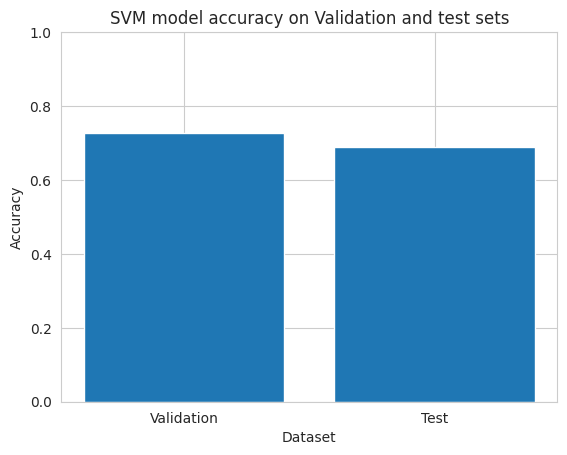

In [64]:
#visualizing 
labels_svm = ['Validation', 'Test']
accuracy_scores = [ val_acc_svm, test_acc_svm]

plt.bar(labels_svm,accuracy_scores)
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('SVM model accuracy on Validation and test sets')
plt.ylim(0,1)
plt.show()

In [65]:
#Print the acuuracy scores
for label, accuracy in zip(labels_svm, accuracy_scores):
    print (f"(label) accuracy: {accuracy:.4f}")

(label) accuracy: 0.7276
(label) accuracy: 0.6881


In [66]:
con_mat = confusion_matrix(y_test_labels, y_test_pred_svm)
print ("Confusion Matrix:")
print (con_mat)

Confusion Matrix:
[[ 25  44   1   6   0   3   1]
 [ 18 399   1  19   1   3   2]
 [  0   4   2   0   0   1   0]
 [ 11  25   2  13   0   1   0]
 [  2   8   1   0   2   2   0]
 [  5  15   4   0   1  13   4]
 [  3  13   1   0   0   7   7]]


In [67]:
class_re = classification_report(y_test_labels, y_test_pred_svm)
print ("Classification Report:")
print (class_re)

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.31      0.35        80
           1       0.79      0.90      0.84       443
           2       0.17      0.29      0.21         7
           3       0.34      0.25      0.29        52
           4       0.50      0.13      0.21        15
           5       0.43      0.31      0.36        42
           6       0.50      0.23      0.31        31

    accuracy                           0.69       670
   macro avg       0.45      0.35      0.37       670
weighted avg       0.66      0.69      0.66       670



Observation

- Class 1 has the highest precision of 0.39 and 0.79 

### Catergorizing the inncorect prediction

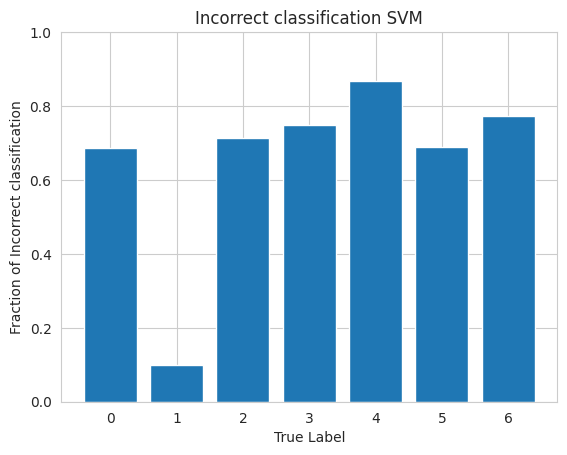

In [69]:
label_error_svm = 1 -np.diag(con_mat)/np.sum(con_mat,axis =1)

plt.bar(np.arange(7),label_error_svm)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect classification')
plt.title('Incorrect classification SVM')
plt.ylim(0,1)
plt.show()

Observation
- The overall validation  accuracy of the model  is 69%
- Class 1 has the highest precision of 0.79 and 0.90 recall refeing that the class 1 is often predict correctly
- Class 1 is melanocytic nevi which has the highest number of sample images and that might be the reason for a better precision and recall

- Class 4 has a lower precision of 0.50 which represents that the prediction is correct half of the time, but the recall is  0.13 reflecting that the model misses many instances in class 4.
- The lowest precision in predicting  is found in class 2.


## ITERATION 2 :CNN <a name="2"></a>

For this iteration we will be using CNN model

### Model Building

In [73]:
img_shape = (75,100,3)
num_classes = 7


Architecture used
1. Input layer : This layer uses the image with a shape (75,100,3)
2. Convolution layer1 : This layer looks for basic shape in the images using 32 different filters.Each filter learns to detect different local patterns or features in the images.
3. Maxpooling Layer1 : This reduces the image size while retaining the important information. This layer helps in controlling overfitting.
4. Convolution layer2 :  Similar to the first convolutional layer, this layer applies 64 filters to the feature maps from the previous layer to capture higher-level features.
5. Maxpooling Layer2 : This layer shrinks the iamge size reating the important details
6. Convolution layer3 : This layer increases the depth of feature extraction by applying 128 filters
7. Maxpooling Layer3 : This final layer of max pooling is used to reduce the spatial dimension 
8. flatten Layer : Th is layer flattens the 3D to 1D vector to prepare for fully connected layer
9. Dense layer1: A fully connected layer with 64 neurons for learning complex relationship in the data
10. Dense layer2 : The final layer with 7 neurons( 7 classes ) which produces the probability distribution over the classes.

In [74]:
###Define the CNN model

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation ='relu',input_shape = img_shape))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(64,(3,3),activation ='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(128,(3,3),activation ='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation ='relu'))
model.add(layers.Dense(7,activation ='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 73, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 30, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 10, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 2, 128)       

In [75]:
###Compile the model

model.compile(optimizer ='adam',
             loss = 'categorical_crossentropy',
             metrics =['accuracy'])

In [76]:
### Train the model 


model1 =model.fit(X_train, y_train,epochs =10,batch_size = 32,validation_data=(X_val,y_val))

Epoch 1/10
76/76 [==============================] - 13s 137ms/step - loss: 1.1294 - accuracy: 0.6856 - val_loss: 0.9603 - val_accuracy: 0.6978
Epoch 2/10
76/76 [==============================] - 9s 123ms/step - loss: 0.9420 - accuracy: 0.6918 - val_loss: 0.9320 - val_accuracy: 0.6978
Epoch 3/10
76/76 [==============================] - 9s 118ms/step - loss: 0.9221 - accuracy: 0.6918 - val_loss: 0.8749 - val_accuracy: 0.6978
Epoch 4/10
76/76 [==============================] - 9s 124ms/step - loss: 0.9118 - accuracy: 0.6931 - val_loss: 0.8926 - val_accuracy: 0.6978
Epoch 5/10
76/76 [==============================] - 10s 126ms/step - loss: 0.8882 - accuracy: 0.6939 - val_loss: 0.8612 - val_accuracy: 0.6978
Epoch 6/10
76/76 [==============================] - 9s 123ms/step - loss: 0.8604 - accuracy: 0.7039 - val_loss: 0.8083 - val_accuracy: 0.7164
Epoch 7/10
76/76 [==============================] - 9s 125ms/step - loss: 0.8303 - accuracy: 0.7105 - val_loss: 0.8229 - val_accuracy: 0.7127
Epoc

In [77]:
#### Evaluate the model

test_loss, test_acc =model.evaluate(X_test, y_test)
val_loss, val_acc =model.evaluate(X_val, y_val)
print("Validation accuracy =%f ;loss_v =%f "%(val_acc,val_loss))
print("Test accuracy =%f ;loss_t =%f "%(test_acc,test_loss))


9/9 [==============================] - 0s 30ms/step - loss: 0.7695 - accuracy: 0.7239
Validation accuracy =0.723881 ;loss_v =0.769497 
Test accuracy =0.677612 ;loss_t =0.943522 


In [78]:
#Showing the plot

def plot_model(modell):
    plt.plot(modell.history['accuracy'])
    plt.plot(modell.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc = 'upper left')
    plt.show()
    
    plt.plot(modell.history['loss'])
    plt.plot(modell.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc = 'upper left')
    plt.show()

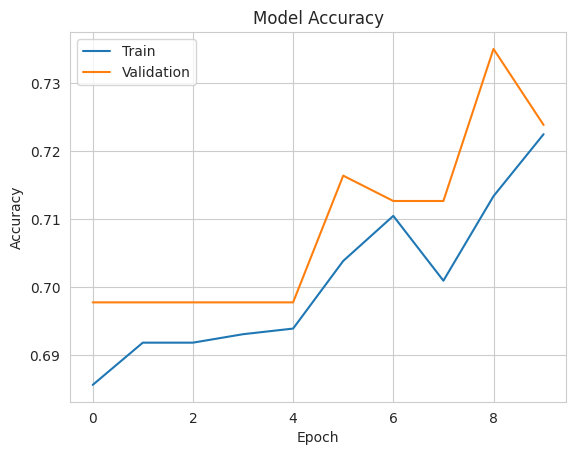

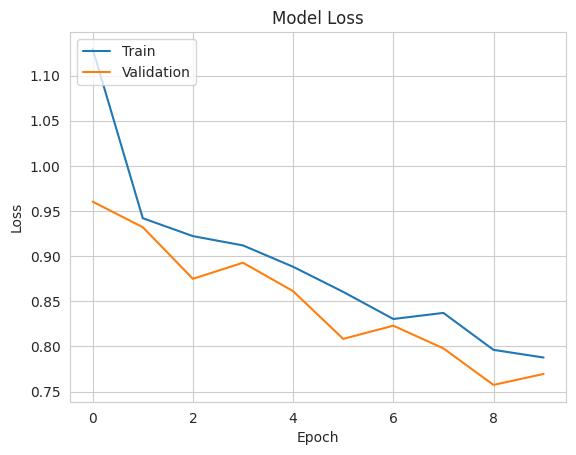

In [79]:
plot_model(model1)

In [80]:

y_pred = model.predict(X_test)

21/21 [==============================] - 1s 31ms/step


In [81]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [82]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Print the classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

Confusion Matrix:
[[ 30  47   0   1   0   2   0]
 [ 16 417   0   9   0   1   0]
 [  4   3   0   0   0   0   0]
 [  7  43   0   1   0   1   0]
 [  4   9   0   0   0   2   0]
 [ 23  13   0   0   0   6   0]
 [ 20  10   0   0   0   1   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.38      0.33        80
           1       0.77      0.94      0.85       443
           2       0.00      0.00      0.00         7
           3       0.09      0.02      0.03        52
           4       0.00      0.00      0.00        15
           5       0.46      0.14      0.22        42
           6       0.00      0.00      0.00        31

    accuracy                           0.68       670
   macro avg       0.23      0.21      0.20       670
weighted avg       0.58      0.68      0.61       670



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


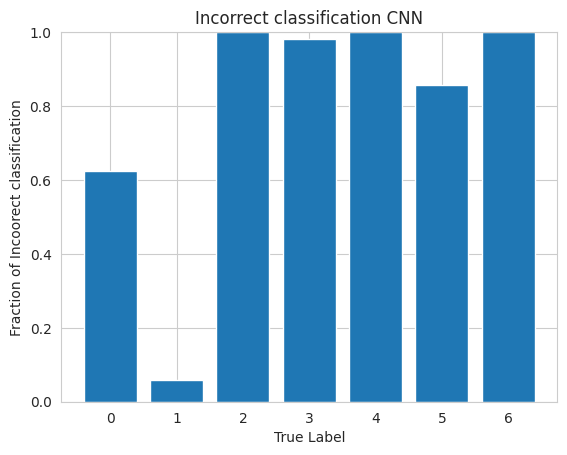

In [83]:
label_error_cnn1= 1 -np.diag(cm)/np.sum(cm,axis =1)

plt.bar(np.arange(7),label_error_cnn1)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incoorect classification')
plt.title('Incorrect classification CNN')
plt.ylim(0,1)
plt.show()

Observation
- The validation and test accuracy remained the same for  CNN model as the SVM model 
- For class 2,3,4 and 6 the precision is 0 indicating that all of the images were incorrectly predicted
- The reason for the poor performance of the model may be because of class imbalance.

## ITERATION 3- SMOTE technique <a name="3"></a>

### CNN MODEL - SMOTE TECHNIQUE 

Using the Smote technique to address the class imbalance in the dataset and changing the model architecture to compare performances

In [84]:
## In the above model let us adress the class imbalance by using SMOTE technique 

#Flattend the image data 

X_train_flat =X_train.reshape(X_train.shape[0],-1)
X_test_flat =X_test.reshape(X_test.shape[0],-1)
X_val_flat =X_val.reshape(X_val.shape[0],-1)


In [85]:
#Address class imbalance using SMOTE
smote =SMOTE(random_state=42)

In [86]:
##Fit and transform the training data 
X_train_resampled_flat,y_train_resampled =smote.fit_resample(X_train_flat,y_train)

In [87]:
##Reshaping 
X_train_resampled = X_train_resampled_flat.reshape(X_train_resampled_flat.shape[0],75,100,3)


Model Architecture

1. Input Layer : Expecting a colored image with dimension of 75 and 100 pixels
2. Convolution Layer 1(x2): This layer wiht 32 filters captures the  patterns in the input images
3. Maxpooling Layer : This layer reduces the image size by 2x2
4. Dropout Layer : This layer helps overfitting by droppping out 25%
The above is repeated twice but this time with convulotion layer of 64 filters
5. Flatten Layer : This layer flattens the 3D to 1D vector to prepare for fully connected layer
6. Dense layer1(x2): A fully connected layer with 256 neurons for learning complex relationship in the data
7. Dropout Layer(x2) : This layer helps overfitting by dropping out 50%
10. Dense layer2 : The final layer with 7 neurons( 7 classes ) which produces the probability distribution over the classes.

In [88]:
#CNN model with new architecture 

model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3),activation ='relu',input_shape = (75,100,3)))
model2.add(layers.Conv2D(32,(3,3),activation ='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(64,(3,3),activation ='relu'))
model2.add(layers.Conv2D(64,(3,3),activation ='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation ='relu'))
model2.add(layers.Dropout(0.5))     
model2.add(layers.Dense(128,activation ='relu'))
model2.add(layers.Dropout(0.5))  
model2.add(layers.Dense(7,activation ='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 73, 98, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 96, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 35, 48, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 33, 46, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 31, 44, 64)        36928     
                                                      

In [89]:
#Compile the model
model2.compile(optimizer ='adam',
               loss = 'categorical_crossentropy',
               metrics =['accuracy'])

In [90]:
#Train_model 
history_model2 = model2.fit(X_train_resampled, y_train_resampled, epochs =20,batch_size = 32, validation_data = (X_val,y_val))

Epoch 1/20


2023-09-07 22:38:30.674714: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1050840000 exceeds 10% of free system memory.


365/365 [==============================] - 226s 615ms/step - loss: 1.6946 - accuracy: 0.3078 - val_loss: 1.0051 - val_accuracy: 0.5821
Epoch 2/20
365/365 [==============================] - 223s 611ms/step - loss: 1.0522 - accuracy: 0.5932 - val_loss: 0.9635 - val_accuracy: 0.6679
Epoch 3/20
365/365 [==============================] - 224s 613ms/step - loss: 0.6193 - accuracy: 0.7789 - val_loss: 1.0032 - val_accuracy: 0.6418
Epoch 4/20
365/365 [==============================] - 224s 615ms/step - loss: 0.4179 - accuracy: 0.8613 - val_loss: 1.0377 - val_accuracy: 0.6567
Epoch 5/20
365/365 [==============================] - 227s 622ms/step - loss: 0.3059 - accuracy: 0.8966 - val_loss: 1.1237 - val_accuracy: 0.6493
Epoch 6/20
365/365 [==============================] - 224s 614ms/step - loss: 0.2274 - accuracy: 0.9231 - val_loss: 1.2869 - val_accuracy: 0.5896
Epoch 7/20
365/365 [==============================] - 221s 606ms/step - loss: 0.1924 - accuracy: 0.9353 - val_loss: 1.2242 - val_accura

In [91]:
#### Evaluate the model

test_loss1, test_acc1 =model2.evaluate(X_test, y_test)
val_loss1, val_acc1 =model2.evaluate(X_val, y_val)
print("Validation accuracy =%f ;loss_v =%f "%(val_acc1,val_loss1))
print("Test accuracy =%f ;loss_t =%f "%(test_acc1,test_loss1))


9/9 [==============================] - 1s 108ms/step - loss: 1.7333 - accuracy: 0.7015
Validation accuracy =0.701493 ;loss_v =1.733296 
Test accuracy =0.700000 ;loss_t =1.956346 


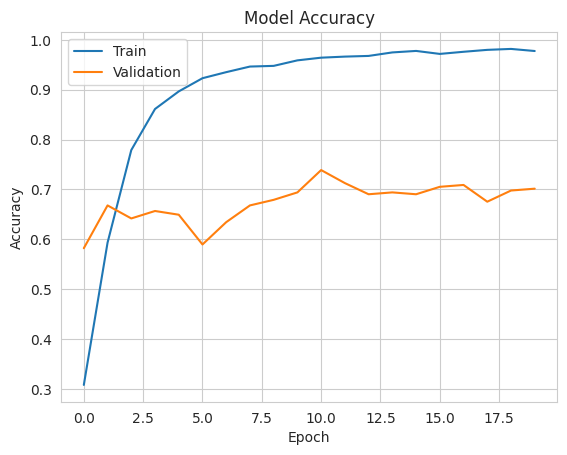

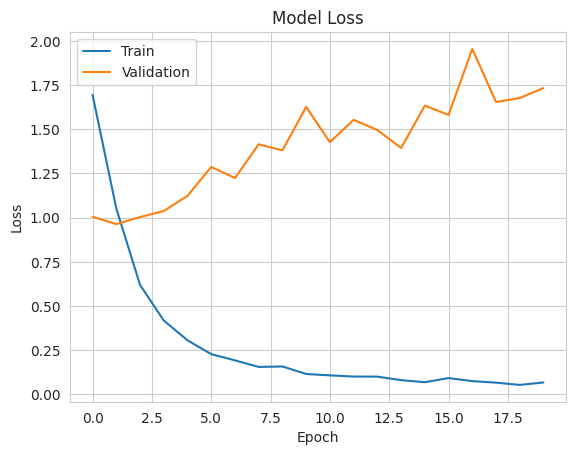

In [92]:
plot_model(history_model2)

In [93]:
y_pred2 = model2.predict(X_test)


y_pred_classes2 = np.argmax(y_pred2, axis=1)




21/21 [==============================] - 3s 114ms/step


In [94]:
cm2 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes2)
print("Confusion Matrix:")
print(cm2)

# Print the classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes2))

Confusion Matrix:
[[ 32  29   2   8   0   4   5]
 [ 19 397   2  18   1   2   4]
 [  1   1   2   2   0   0   1]
 [  9  26   1  14   0   2   0]
 [  2   4   0   1   8   0   0]
 [ 11   9   0   3   0  10   9]
 [ 10   8   1   2   0   4   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.40      0.39        80
           1       0.84      0.90      0.87       443
           2       0.25      0.29      0.27         7
           3       0.29      0.27      0.28        52
           4       0.89      0.53      0.67        15
           5       0.45      0.24      0.31        42
           6       0.24      0.19      0.21        31

    accuracy                           0.70       670
   macro avg       0.48      0.40      0.43       670
weighted avg       0.68      0.70      0.69       670



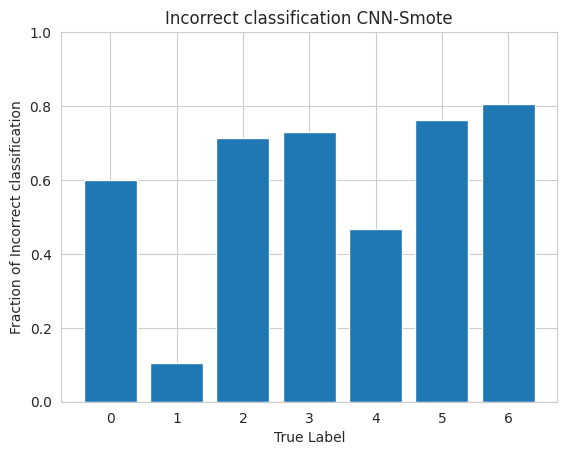

In [95]:
label_error_cnn2= 1 -np.diag(cm2)/np.sum(cm2,axis =1)

plt.bar(np.arange(7),label_error_cnn2)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect classification')
plt.title('Incorrect classification CNN-Smote')
plt.ylim(0,1)
plt.show()

Observation
- The overall  accuracy of the model is close to the previous ieration  at 70%.
- Class 1 has highest recall and precision which reflects that the class 1 was correctly predicted at most instances 
- Class 4 precision has also improved indicating that most of them were predicted correctly but there was a low recall indicating that most often it was missed.
- Class 2,3,5,6 were challenging to predict 

## ITERATION 4 -Data Augumentation <a name="4"></a>

Using data augmentation to handle class imbalance

In [97]:
#CNN model with new architecture 

model3 = models.Sequential()
model3.add(layers.Conv2D(32,(3,3),activation ='relu',input_shape = (75,100,3)))
model3.add(layers.Conv2D(32,(3,3),activation ='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv2D(64,(3,3),activation ='relu'))
model3.add(layers.Conv2D(64,(3,3),activation ='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Dropout(0.25))
model3.add(layers.Flatten())
model3.add(layers.Dense(256,activation ='relu'))
model3.add(layers.Dropout(0.5))     
model3.add(layers.Dense(128,activation ='relu'))
model3.add(layers.Dropout(0.5))  
model3.add(layers.Dense(7,activation ='softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 73, 98, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 96, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 35, 48, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 33, 46, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 31, 44, 64)        36928     
                                                      

In [98]:
#Compile the model
model3.compile(optimizer ='Adam',
               loss = 'categorical_crossentropy',
               metrics =['accuracy'])

In [99]:
datagen = ImageDataGenerator(
    rotation_range =20,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

datagen.fit(X_train_resampled)
# Learning rate scheduling function
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001
    
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [100]:
#Train_model 
history_model3 = model3.fit(
    datagen.flow(X_train_resampled, y_train_resampled,batch_size = 16),
    steps_per_epoch=len(X_train_resampled)/32,
    epochs =20,
    validation_data=(X_val, y_val),
    callbacks=[LearningRateScheduler(learning_rate_scheduler), early_stopping]
)


Epoch 1/20
364/364 [==============================] - 126s 341ms/step - loss: 1.8510 - accuracy: 0.2110 - val_loss: 1.3728 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 2/20
364/364 [==============================] - 123s 337ms/step - loss: 1.6931 - accuracy: 0.2587 - val_loss: 1.1668 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 3/20
364/364 [==============================] - 123s 336ms/step - loss: 1.6324 - accuracy: 0.2988 - val_loss: 1.1672 - val_accuracy: 0.5261 - lr: 0.0010
Epoch 4/20
364/364 [==============================] - 123s 337ms/step - loss: 1.5927 - accuracy: 0.3204 - val_loss: 1.4710 - val_accuracy: 0.1455 - lr: 0.0010
Epoch 5/20
364/364 [==============================] - 122s 334ms/step - loss: 1.5467 - accuracy: 0.3533 - val_loss: 1.1638 - val_accuracy: 0.4664 - lr: 0.0010
Epoch 6/20
364/364 [==============================] - 123s 338ms/step - loss: 1.4413 - accuracy: 0.3892 - val_loss: 1.2963 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 7/20
364/364 [==========================

In [101]:
#### Evaluate the model

test_loss2, test_acc2 =model3.evaluate(X_test, y_test)
val_loss2, val_acc2 =model3.evaluate(X_val, y_val)
print("Validation accuracy =%f ;loss_v =%f "%(val_acc2,val_loss2))
print("Test accuracy =%f ;loss_t =%f "%(test_acc2,test_loss2))


9/9 [==============================] - 1s 108ms/step - loss: 0.9373 - accuracy: 0.5560
Validation accuracy =0.555970 ;loss_v =0.937292 
Test accuracy =0.508955 ;loss_t =1.161156 


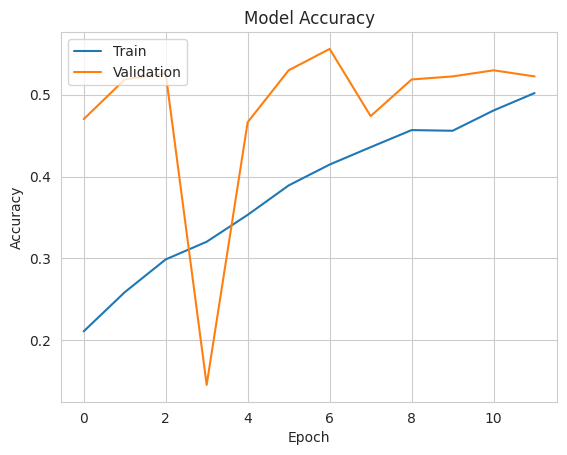

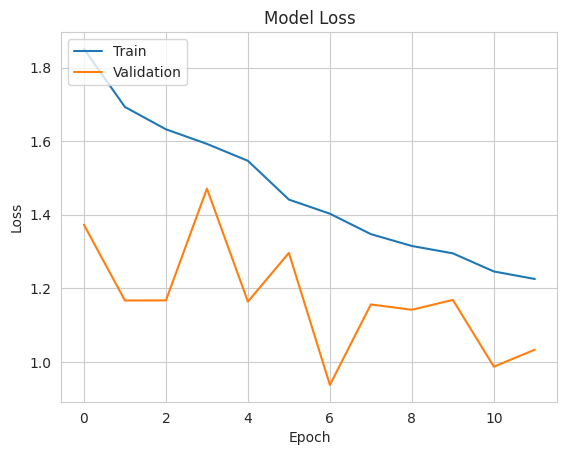

In [102]:
plot_model(history_model3)

In [103]:
y_pred3 = model3.predict(X_test)


y_pred_classes3 = np.argmax(y_pred3, axis=1)



21/21 [==============================] - 2s 113ms/step


In [104]:
cm3 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes3)
print("Confusion Matrix:")
print(cm3)

# Print the classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes3))

Confusion Matrix:
[[ 16   7   3  41   4   2   7]
 [ 18 270   1 139   8   1   6]
 [  1   0   1   4   1   0   0]
 [  2   9   1  38   2   0   0]
 [  1   0   0   3  11   0   0]
 [  8   3   2  15   2   2  10]
 [ 11   0   2  14   0   1   3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.20      0.23        80
           1       0.93      0.61      0.74       443
           2       0.10      0.14      0.12         7
           3       0.15      0.73      0.25        52
           4       0.39      0.73      0.51        15
           5       0.33      0.05      0.08        42
           6       0.12      0.10      0.11        31

    accuracy                           0.51       670
   macro avg       0.33      0.37      0.29       670
weighted avg       0.70      0.51      0.56       670



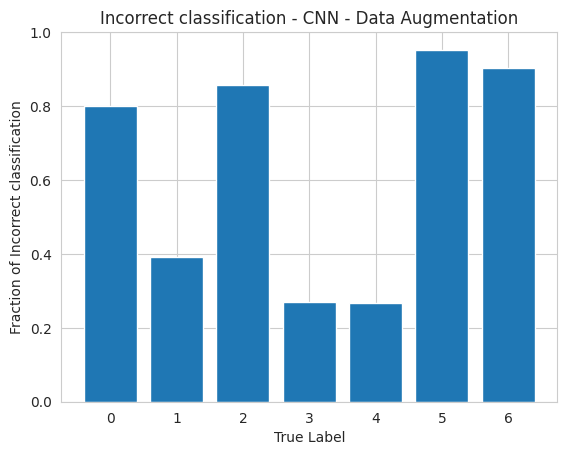

In [105]:
label_error_cnn3= 1 -np.diag(cm3)/np.sum(cm3,axis =1)

plt.bar(np.arange(7),label_error_cnn3)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect classification')
plt.title('Incorrect classification - CNN - Data Augmentation')
plt.ylim(0,1)
plt.show()

Observation:
- For this model the acuuracy has drastically decreased to an average of 51% 
- the incorrect classification has changed for this model class 2 had a significant low precision  
- The class one had good F1 score indicating that the prediction was good and accurate
- Overall the model had varied performance with each class

## ITERATION 5-Transfer Learning <a name="5"></a>

In [106]:
base_model =VGG16(weights ='imagenet', include_top =False,input_shape =(75,100,3))

#Freeze the convolutional layers to prevent from training
for layer in base_model.layers:
    layer.trainable =False
    
#Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x= Dropout(0.5)(x)
x = Dense(7, activation ='softmax')(x)

In [107]:
#Creating a new transfer model
model_transfer = Model(inputs =base_model.input, outputs =x)

In [108]:
#Compile the model
model_transfer.compile(optimizer = Adam(lr = 0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
#Create an Image DataGeberator 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train_resampled)

In [110]:
# Train the transfer learning model with data augmentation
history_transfer = model_transfer.fit(
    datagen.flow(X_train_resampled, y_train_resampled, batch_size=32),
    steps_per_epoch=len(X_train_resampled) / 32,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
364/364 [==============================] - 439s 1s/step - loss: 1.4160 - accuracy: 0.4619 - val_loss: 1.4079 - val_accuracy: 0.4030
Epoch 2/20
364/364 [==============================] - 436s 1s/step - loss: 1.1596 - accuracy: 0.5485 - val_loss: 1.1992 - val_accuracy: 0.5485
Epoch 3/20
364/364 [==============================] - 437s 1s/step - loss: 1.0417 - accuracy: 0.5990 - val_loss: 1.1958 - val_accuracy: 0.5485
Epoch 4/20
364/364 [==============================] - 435s 1s/step - loss: 0.9757 - accuracy: 0.6271 - val_loss: 1.1411 - val_accuracy: 0.5336
Epoch 5/20
364/364 [==============================] - 436s 1s/step - loss: 0.9252 - accuracy: 0.6495 - val_loss: 1.2248 - val_accuracy: 0.5037
Epoch 6/20
364/364 [==============================] - 435s 1s/step - loss: 0.8770 - accuracy: 0.6666 - val_loss: 1.1289 - val_accuracy: 0.5522
Epoch 7/20
364/364 [==============================] - 437s 1s/step - loss: 0.8388 - accuracy: 0.6807 - val_loss: 1.0582 - val_accuracy: 0.6119

In [111]:
## Evaluate the model 

test_loss3, test_acc3 =model_transfer.evaluate(X_test, y_test)
val_loss3, val_acc3 =model_transfer.evaluate(X_val, y_val)
print("Validation accuracy =%f ;loss_v =%f "%(val_acc3,val_loss3))
print("Test accuracy =%f ;loss_t =%f "%(test_acc3,test_loss3))


9/9 [==============================] - 10s 1s/step - loss: 1.1073 - accuracy: 0.6231
Validation accuracy =0.623134 ;loss_v =1.107260 
Test accuracy =0.644776 ;loss_t =1.151405 


In [112]:
y_pred4 = model_transfer.predict(X_test)

y_pred_classes4 = np.argmax(y_pred4, axis=1)

21/21 [==============================] - 23s 1s/step


In [113]:
cm4 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes4)
print("Confusion Matrix:")
print(cm4)

# Print the classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes4))

Confusion Matrix:
[[ 33  13   2  19   0   8   5]
 [ 32 312  14  64   0  14   7]
 [  0   1   2   0   1   3   0]
 [  5   8   0  35   0   2   2]
 [  2   2   0   2   7   2   0]
 [  1   6   0   4   0  28   3]
 [  3   1   0   2   0  10  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.41      0.42        80
           1       0.91      0.70      0.79       443
           2       0.11      0.29      0.16         7
           3       0.28      0.67      0.39        52
           4       0.88      0.47      0.61        15
           5       0.42      0.67      0.51        42
           6       0.47      0.48      0.48        31

    accuracy                           0.64       670
   macro avg       0.50      0.53      0.48       670
weighted avg       0.74      0.64      0.68       670



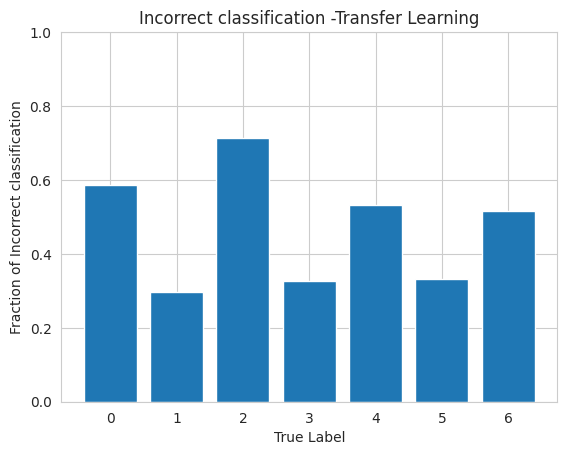

In [114]:
label_error_cnn4= 1 -np.diag(cm4)/np.sum(cm4,axis =1)

plt.bar(np.arange(7),label_error_cnn4)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect classification')
plt.title('Incorrect classification -Transfer Learning')
plt.ylim(0,1)
plt.show()

Observation
- The accuracy of the model is 64% overall 
- As usual class 1 performance hasd higher precision as well as class 4 perfomed well 
- Class 2 faced challenge in predictiion as it had the lowest prediction.

## Comparision of different Interation<a name="comp"></a>

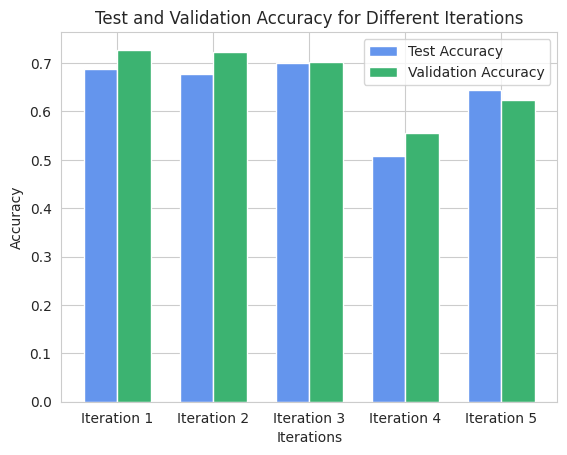

In [116]:
models = ['Iteration 1', 'Iteration 2','Iteration 3', 'Iteration 4','Iteration 5']

accuracy_scores = [test_acc_svm, test_acc,test_acc1,test_acc2,test_acc3]
val_accuracy_scores =[val_acc_svm,val_acc,val_acc1,val_acc2,val_acc3]

# Set the width of the bars
bar_width = 0.35

# Create an array that represents the x-axis positions for the bars
x = range(len(models))

# Create the bar plots for test accuracy and validation accuracy
plt.bar(x, accuracy_scores, width=bar_width, label='Test Accuracy', color = 'cornflowerblue')
plt.bar([i + bar_width for i in x], val_accuracy_scores, width=bar_width, label='Validation Accuracy',color = 'mediumseagreen')

# Set the x-axis labels and title
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Test and Validation Accuracy for Different Iterations')
plt.xticks([i + bar_width / 2 for i in x], models)

# Add a legend
plt.legend()

# Show the plot
plt.show()


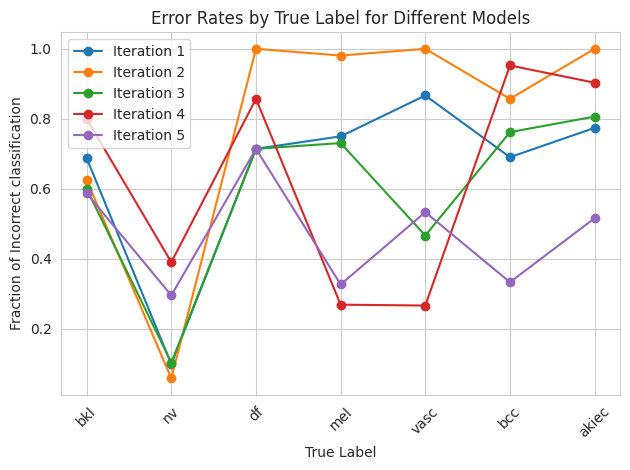

In [118]:


# Define the true labels (x-axis labels)
true_labels = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

# Combine the error rates from all three models 
label_errors = [label_error_svm,label_error_cnn1, label_error_cnn2, label_error_cnn3,label_error_cnn4]

# Create an array of positions 
x = np.arange(len(true_labels))


# Create a line plot for each model
for i, label_error in enumerate(label_errors):
    plt.plot(true_labels, label_error, label=f'Iteration {i+1}', marker='o')


plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect classification')
plt.legend()
plt.title('Error Rates by True Label for Different Models')
plt.xticks(rotation=45)
plt.grid(True) 
plt.tight_layout()  
plt.show()



Looking at all five iterations, it was clear that iteration 3 outperformed the others with an accuracy of 70%.
The scores for iteration 3, in which we used the CNN model and the SMOTE technique, were as follows:
- Precision: Weighted average precision of approximately 0.70
- Recall: Weighted average recall of approximately 0.70
- F1-Score: Weighted average F1-score of approximately 0.69
For iteration 3 the high F1 score indicates that it had a balanced recall and precision, making it the best performing iteration.

For iteration 5, where we used transfer learning the accuracy was 64%

- Precision: Weighted average precision of approximately 0.64
- Recall: Weighted average recall of approximately 0.64
- F1-Score: Weighted average F1-score of approximately 0.64

In terms of  Score, it had a balanced recall and precision, making it the second best iteration.


Throughout all iterations, Class 1, which stands for melanocytic nevi (frequently referred to as moles), consistently received the highest F1 Score. This impressive performance can be due to the fact that among the seven lesion types, class one had the most photos (2298) in the dataset.


## Conclusion <a name="con"></a>

 The  CNN model with the following architecture  can be used to detect the pigmented skin lesion types, while incorporating the SMOTE technique to handle class imbalance. 
 
 conv2d_6 (Conv2D)              (None, 73, 98, 32)                                                                         
 conv2d_7 (Conv2D)              (None, 71, 96, 32)                                                                             
 max_pooling2d_6 (MaxPooling 2D)(None, 35, 48, 32)                                                                                                                                 
 dropout (Dropout)              (None, 35, 48, 32)                                                                              
 conv2d_8 (Conv2D)              (None, 33, 46, 64)                                                                          
 conv2d_9 (Conv2D)              (None, 31, 44, 64)                                                                          
 max_pooling2d_7 (MaxPooling 2D)(None, 15, 22, 64)                                                                                                                                 
 dropout_1 (Dropout)            (None, 15, 22, 64)                                                                              
 flatten_2 (Flatten)            (None, 21120)                                                                                     
 dense_4 (Dense)                (None, 256)                                                                             
 dropout_2 (Dropout)            (None, 256)                                                                                     
 dense_5 (Dense)                (None, 128)                                                                                
 dropout_3 (Dropout)            (None, 128)                                                                                    
 dense_6 (Dense)                (None, 7)  
 
 According to the National Library of medicine study(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7519424/) the accuracy of dermatologist was around 65.0% with sensistivity(recall) of 59.4% whereas the model accuracy  and recall was 70%, which clearly indicates that with the help of the above machine learning model Dermatologist or clinicians will be able to detect the lesion type at a much faster rate with better accuracy.

______________________________________________________________________________________